In [29]:
# === 0) Setup & Load ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Project paths
PROJECT_ROOT = Path("..").resolve()
RES_DIR   = PROJECT_ROOT / "results"
FIG_DIR   = RES_DIR / "figures"
MODEL_DIR = RES_DIR / "models"

for p in (RES_DIR, FIG_DIR, MODEL_DIR):
    p.mkdir(exist_ok=True, parents=True)

# Data path (feature-engineered loans)
DATA_PATH = PROJECT_ROOT / "data_work" / "loans_fe.parquet"

df = pd.read_parquet(DATA_PATH)

TARGET   = "target"
TIME_COL = "issue_q_start"

In [30]:
# Ensure time column is proper datetime for time-based splitting
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

print("Data shape:", df.shape)
print("Time span:", df[TIME_COL].min(), "→", df[TIME_COL].max())
df.head()


Data shape: (2258953, 33)
Time span: 2007-04-01 00:00:00 → 2018-10-01 00:00:00


,issue_q_start,loan_amnt,term_m,int_rate,dti,fico,emp_length,GDPC1,UNRATE,CPIAUCSL,...,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,UNRATE_delta_qoq,FEDFUNDS_delta_qoq,GDPC1_delta_qoq,inflation_qoq,real_rate_qoq
0,2007-04-01,7500,36,0.1375,14.29,660,0.5,16713.314,4.5,206.631,...,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0
1,2007-04-01,6000,36,0.1059,12.90,695,0.5,16713.314,4.5,206.631,...,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0
2,2007-04-01,4400,36,0.0964,3.72,695,2.0,16713.314,4.5,206.631,...,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0
3,2007-04-01,1200,36,0.0901,3.27,705,0.5,16713.314,4.5,206.631,...,False,False,False,True,False,0.0,0.0,0.0,0.0,0.0
4,2007-04-01,5000,36,0.1122,3.51,670,0.5,16713.314,4.5,206.631,...,False,False,False,True,False,0.0,0.0,0.0,0.0,0.0


In [31]:
# === 1) Time-based Split: train / validation / test ==========================
'''Train:      issue_q_start < 2017-01-01
Validation: 2017-01-01 <= issue_q_start < 2018-01-01
Test:       issue_q_start >= 2018-01-01'''

train_df = df[df[TIME_COL] < "2017-01-01"].copy()
val_df   = df[(df[TIME_COL] >= "2017-01-01") & (df[TIME_COL] < "2018-01-01")].copy()
test_df  = df[df[TIME_COL] >= "2018-01-01"].copy()

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("Train years:",  sorted(train_df[TIME_COL].dt.year.unique()))
print("Val years:",    sorted(val_df[TIME_COL].dt.year.unique()))
print("Test years:",   sorted(test_df[TIME_COL].dt.year.unique()))




Train size: 1321778
Validation size: 443065
Test size: 494110
Train years: [np.int32(2007), np.int32(2008), np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016)]
Val years: [np.int32(2017)]
Test years: [np.int32(2018)]


In [32]:
# --- Feature / target split --------------------------------------------------
FEATURES = [c for c in df.columns if c not in [TARGET, TIME_COL]]

X_train = train_df[FEATURES]
y_train = train_df[TARGET].astype(int)

X_val = val_df[FEATURES]
y_val = val_df[TARGET].astype(int)

X_test = test_df[FEATURES]
y_test = test_df[TARGET].astype(int)

print("X_train:", X_train.shape, " default rate:", y_train.mean())
print("X_val:  ", X_val.shape,   " default rate:", y_val.mean())
print("X_test: ", X_test.shape,  " default rate:", y_test.mean())

X_train: (1321778, 31)  default rate: 0.16742826707661954
X_val:   (443065, 31)  default rate: 0.0883233837021656
X_test:  (494110, 31)  default rate: 0.01791706300216551


In [33]:
# === 2) Preprocessor: scale only continuous numeric features; passthrough booleans ===
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Continuous numeric features: numeric dtype with more than 2 unique values
cont_cols = [
    c for c in X_train.columns
    if np.issubdtype(X_train[c].dtype, np.number) and X_train[c].nunique() > 2
]

# Boolean one-hot features (True/False)
bool_cols = X_train.select_dtypes(include=["bool"]).columns.tolist()

# Any remaining numeric 0/1 dummy columns that are not in cont_cols or bool_cols
bin_num_cols = [
    c for c in X_train.columns
    if c not in cont_cols and c not in bool_cols
]

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), cont_cols),                 # scale continuous
        ("bool", "passthrough", bool_cols + bin_num_cols),    # pass through binary features
    ],
    remainder="drop",
)

print(f"Scaling {len(cont_cols)} continuous features; "
      f"passing through {len(bool_cols) + len(bin_num_cols)} binary features.")


Scaling 15 continuous features; passing through 16 binary features.


In [34]:
cont_cols

['loan_amnt',
 'int_rate',
 'dti',
 'fico',
 'emp_length',
 'GDPC1',
 'UNRATE',
 'CPIAUCSL',
 'FEDFUNDS',
 'log_annual_inc',
 'UNRATE_delta_qoq',
 'FEDFUNDS_delta_qoq',
 'GDPC1_delta_qoq',
 'inflation_qoq',
 'real_rate_qoq']

In [35]:
bool_cols

['grade_b',
 'grade_c',
 'grade_d',
 'grade_e',
 'grade_f',
 'home_ownership_mortgage',
 'home_ownership_own',
 'home_ownership_rent',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_other',
 'purpose_small_business']

In [36]:
bin_num_cols

['term_m']

In [37]:
# === 3) Train class-balanced Logistic Regression =============================
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

logreg = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        solver="lbfgs"
    )),
])

# Fit on training data only
logreg.fit(X_train, y_train)

# Predict probabilities on train / val / test
proba_lr_train = logreg.predict_proba(X_train)[:, 1]
proba_lr_val   = logreg.predict_proba(X_val)[:, 1]
proba_lr_test  = logreg.predict_proba(X_test)[:, 1]

# AUC on train / val / test
auc_train = roc_auc_score(y_train, proba_lr_train)
auc_val   = roc_auc_score(y_val,   proba_lr_val)
auc_test  = roc_auc_score(y_test,  proba_lr_test)

print(f"LogReg AUC — train: {auc_train:.3f}  "
      f"val: {auc_val:.3f}  "
      f"test: {auc_test:.3f}")


LogReg AUC — train: 0.690  val: 0.697  test: 0.726


In [38]:
# Compute binary cross-entropy (log-loss)
train_loss = log_loss(y_train, proba_lr_train)
val_loss   = log_loss(y_val,   proba_lr_val)
test_loss  = log_loss(y_test,  proba_lr_test)

print(f"Logistic Regression log-loss:")
print(f"  train: {train_loss:.4f}")
print(f"  val:   {val_loss:.4f}")
print(f"  test:  {test_loss:.4f}")

Logistic Regression log-loss:
  train: 0.6365
  val:   0.4728
  test:  0.2627


In [39]:
# === 4) Tree model: XGBoost if available; else HistGradientBoostingClassifier ===
proba_xgb_train = proba_xgb_val = proba_xgb_test = None

try:
    from xgboost import XGBClassifier

    # Class imbalance handling via scale_pos_weight
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    spw = max(1.0, neg / max(1, pos))

    xgb = Pipeline([
        ("pre", pre),
        ("clf", XGBClassifier(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.07,
            subsample=0.9,
            colsample_bytree=0.9,
            min_child_weight=1.0,
            reg_lambda=1.0,
            objective="binary:logistic",
            eval_metric="auc",
            tree_method="hist",
            random_state=42,
            scale_pos_weight=spw,
        )),
    ])

    xgb.fit(X_train, y_train)

    proba_xgb_train = xgb.predict_proba(X_train)[:, 1]
    proba_xgb_val   = xgb.predict_proba(X_val)[:, 1]
    proba_xgb_test  = xgb.predict_proba(X_test)[:, 1]

    auc_train = roc_auc_score(y_train, proba_xgb_train)
    auc_val   = roc_auc_score(y_val,   proba_xgb_val)
    auc_test  = roc_auc_score(y_test,  proba_xgb_test)

    loss_train = log_loss(y_train, proba_xgb_train)
    loss_val   = log_loss(y_val,   proba_xgb_val)
    loss_test  = log_loss(y_test,  proba_xgb_test)

    print("XGBoost performance:")
    print(f"  AUC   — train: {auc_train:.3f}  val: {auc_val:.3f}  test: {auc_test:.3f}")
    print(f"  loss  — train: {loss_train:.4f} val: {loss_val:.4f} test: {loss_test:.4f}")

except Exception as e:
    # Fallback: HistGradientBoostingClassifier (no external deps, works fine on Mac)
    from sklearn.ensemble import HistGradientBoostingClassifier
    from sklearn.utils._response import _sigmoid

    hgb = Pipeline([
        ("pre", pre),
        ("clf", HistGradientBoostingClassifier(
            max_depth=4,
            learning_rate=0.07,
            random_state=42,
        )),
    ])

    hgb.fit(X_train, y_train)

    # Try predict_proba if available (newer sklearn); else use decision_function
    try:
        proba_xgb_train = hgb.predict_proba(X_train)[:, 1]
        proba_xgb_val   = hgb.predict_proba(X_val)[:, 1]
        proba_xgb_test  = hgb.predict_proba(X_test)[:, 1]
    except Exception:
        proba_xgb_train = _sigmoid(hgb.decision_function(X_train))
        proba_xgb_val   = _sigmoid(hgb.decision_function(X_val))
        proba_xgb_test  = _sigmoid(hgb.decision_function(X_test))

    auc_train = roc_auc_score(y_train, proba_xgb_train)
    auc_val   = roc_auc_score(y_val,   proba_xgb_val)
    auc_test  = roc_auc_score(y_test,  proba_xgb_test)

    loss_train = log_loss(y_train, proba_xgb_train)
    loss_val   = log_loss(y_val,   proba_xgb_val)
    loss_test  = log_loss(y_test,  proba_xgb_test)

    print("HistGradientBoosting performance:")
    print(f"  AUC   — train: {auc_train:.3f}  val: {auc_val:.3f}  test: {auc_test:.3f}")
    print(f"  loss  — train: {loss_train:.4f} val: {loss_val:.4f} test: {loss_test:.4f}")

    xgb = hgb  # alias for downstream naming


XGBoost performance:
  AUC   — train: 0.703  val: 0.701  test: 0.674
  loss  — train: 0.6276 val: 0.5418 test: 0.5178


In [40]:
# === 5) Full evaluation (AUC + log-loss + basic classification) + figures ===

from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, precision_score, recall_score,
    RocCurveDisplay, PrecisionRecallDisplay, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, log_loss
)

metrics = []



In [41]:
# 5.1 Collect metrics for each model and split (train / val / test)

def add_model_metrics(model_name, split_name, y_true, y_proba, threshold=0.5):
    """Add one row of metrics for a given model and data split."""
    y_pred = (y_proba >= threshold).astype(int)

    metrics.append({
        "model": model_name,
        "split": split_name,
        "threshold": threshold,
        "log_loss": log_loss(y_true, y_proba),
        "auc": roc_auc_score(y_true, y_proba),
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "default_rate": float(y_true.mean()),
        "pred_mean_pd": float(y_proba.mean()),
        "pred_default_rate": float(y_pred.mean()),
    })


In [42]:
# --- Logistic Regression (main model) --------------------------------------
add_model_metrics("logistic", "train", y_train, proba_lr_train)
add_model_metrics("logistic", "val",   y_val,   proba_lr_val)
add_model_metrics("logistic", "test",  y_test,  proba_lr_test)

In [43]:
# --- Tree model (XGBoost / HGB), if available ------------------------------
if proba_xgb_train is not None and proba_xgb_val is not None and proba_xgb_test is not None:
    add_model_metrics("tree", "train", y_train, proba_xgb_train)
    add_model_metrics("tree", "val",   y_val,   proba_xgb_val)
    add_model_metrics("tree", "test",  y_test,  proba_xgb_test)

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

,model,split,threshold,log_loss,auc,accuracy,f1,precision,recall,default_rate,pred_mean_pd,pred_default_rate
0,logistic,train,0.5,0.636544,0.689921,0.619941,0.369200,0.255639,0.664297,0.167428,0.463137,0.435075
1,logistic,val,0.5,0.472771,0.696841,0.811876,0.250002,0.192939,0.354995,0.088323,0.337709,0.162509
2,logistic,test,0.5,0.262741,0.725814,0.950430,0.093020,0.069193,0.141873,0.017917,0.204853,0.036737
3,tree,train,0.5,0.627556,0.703332,0.629671,0.378394,0.263151,0.673222,0.167428,0.458758,0.428334
4,tree,val,0.5,0.541831,0.700843,0.735366,0.254154,0.169195,0.510490,0.088323,0.394414,0.266487
5,tree,test,0.5,0.517830,0.673724,0.725092,0.060661,0.032308,0.495425,0.017917,0.377156,0.274744


In [44]:
# Save to CSV for later use (paper tables, etc.)
metrics_path = RES_DIR / "model_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)

/Users/binodtandan/UNT Research/ai_stress_testing/venv/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/Users/binodtandan/UNT Research/ai_stress_testing/venv/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


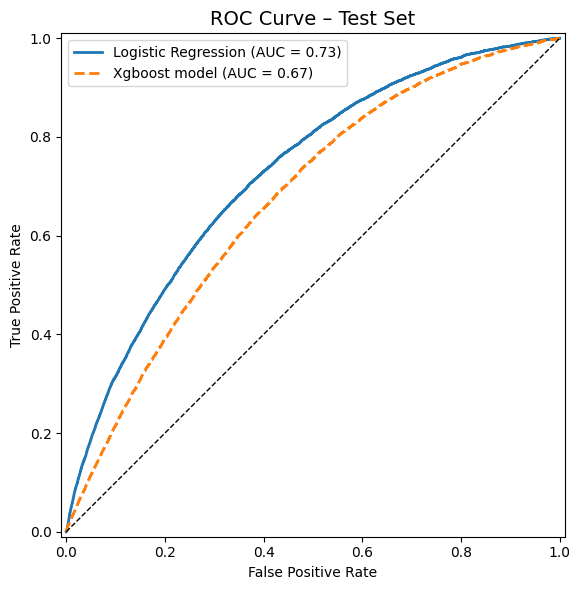

In [45]:
# 5.2 ROC Curve (Test set) – Logistic vs Tree

plt.close("all")  # clear any old figures

fig, ax = plt.subplots(figsize=(7, 6))

RocCurveDisplay.from_predictions(
    y_test, proba_lr_test,
    name="Logistic Regression", linewidth=2, ax=ax
)

if proba_xgb_test is not None:
    RocCurveDisplay.from_predictions(
        y_test, proba_xgb_test,
        name="Xgboost model", linewidth=2, linestyle="--", ax=ax
    )

ax.plot([0, 1], [0, 1], "k--", linewidth=1)
ax.set_title("ROC Curve – Test Set", fontsize=14)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()

roc_path = FIG_DIR / "roc_curve_test_logreg_vs_xgboost.png"
fig.tight_layout()
fig.savefig(roc_path, dpi=300)
plt.show()


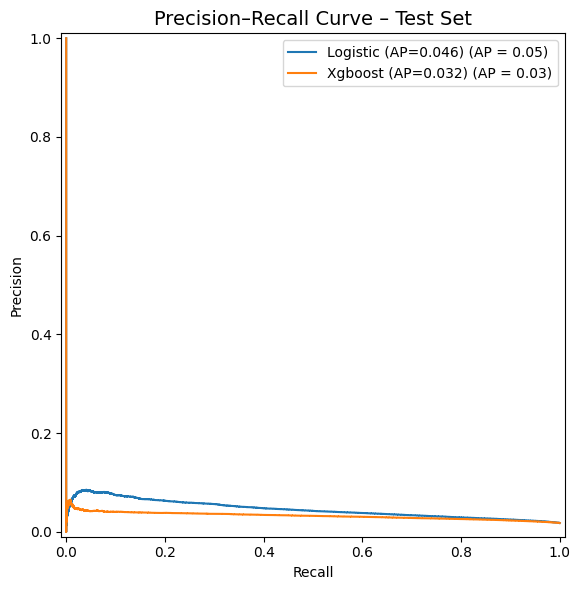

In [46]:
# 5.3 Precision–Recall Curve (Test set) – Logistic vs Tree

plt.close("all")  # remove all stale figures

fig, ax = plt.subplots(figsize=(7, 6))

# Logistic Regression
PrecisionRecallDisplay.from_predictions(
    y_test, proba_lr_test,
    name=f"Logistic (AP={average_precision_score(y_test, proba_lr_test):.3f})",
    ax=ax
)

# XGBoost
if proba_xgb_test is not None:
    PrecisionRecallDisplay.from_predictions(
        y_test, proba_xgb_test,
        name=f"Xgboost (AP={average_precision_score(y_test, proba_xgb_test):.3f})",
        ax=ax
    )

ax.set_title("Precision–Recall Curve – Test Set", fontsize=14)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()

fig.tight_layout()

pr_path = FIG_DIR / "pr_curve_test_logreg_vs_xgboost.png"
fig.savefig(pr_path, dpi=300)
plt.show()

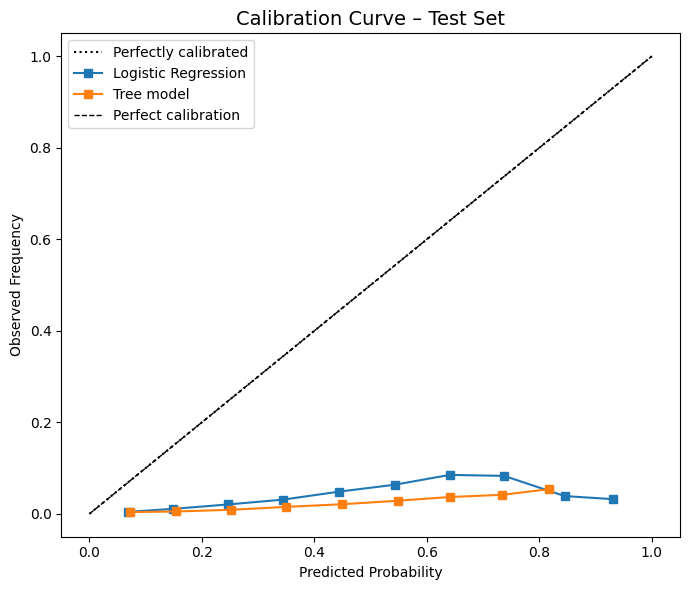

In [49]:
# Calibration Curve (Test set)
from sklearn.calibration import CalibrationDisplay

plt.figure(figsize=(7, 6))

# Logistic Regression calibration
CalibrationDisplay.from_predictions(
    y_test,
    proba_lr_test,
    name="Logistic Regression",
    n_bins=10,
    ax=plt.gca()
)

# Tree model (XGBoost / HGB) calibration, if available
if proba_xgb_test is not None:
    CalibrationDisplay.from_predictions(
        y_test,
        proba_xgb_test,
        name="Tree model",
        n_bins=10,
        ax=plt.gca()
    )

# Reference line
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Perfect calibration")

plt.title("Calibration Curve – Test Set", fontsize=14)
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.legend()
plt.tight_layout()

calib_path = FIG_DIR / "calibration_curve_test.png"
plt.savefig(calib_path, dpi=300)
plt.show()

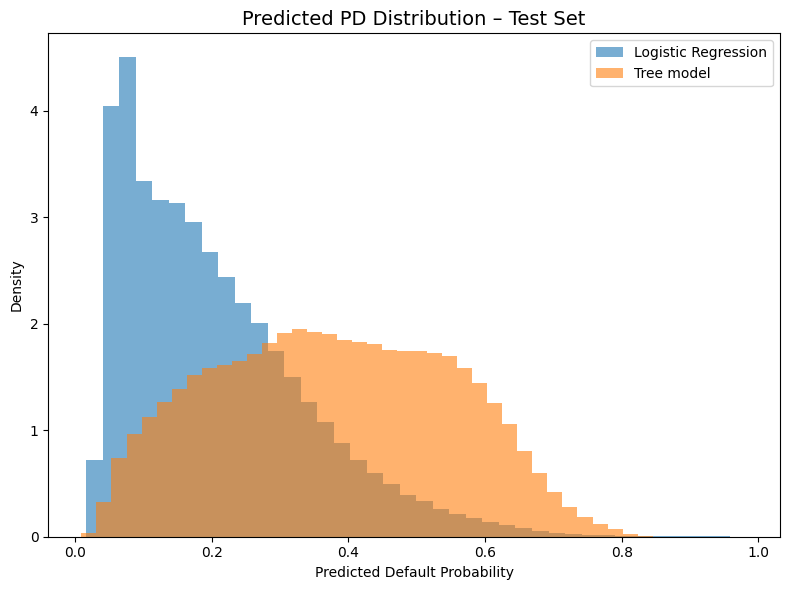

In [50]:
plt.figure(figsize=(8, 6))

# Logistic Regression PDs
plt.hist(
    proba_lr_test,
    bins=40,
    alpha=0.6,
    label="Logistic Regression",
    density=True
)

# Tree model PDs (if available)
if proba_xgb_test is not None:
    plt.hist(
        proba_xgb_test,
        bins=40,
        alpha=0.6,
        label="Tree model",
        density=True
    )

plt.title("Predicted PD Distribution – Test Set", fontsize=14)
plt.xlabel("Predicted Default Probability")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()

pd_hist_path = FIG_DIR / "pd_histogram_test.png"
plt.savefig(pd_hist_path, dpi=300)
plt.show()

<Figure size 600x500 with 0 Axes>

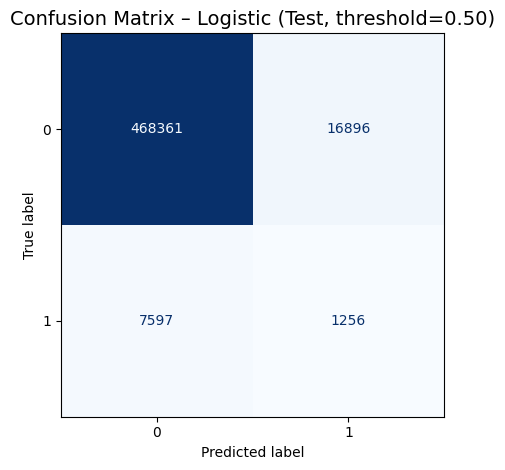

In [47]:
# 5.4 Confusion Matrix (Test set, Logistic, threshold = 0.5)

threshold_cm = 0.5
y_test_pred_lr = (proba_lr_test >= threshold_cm).astype(int)

cm = confusion_matrix(y_test, y_test_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(6, 5))
disp.plot(values_format="d", cmap="Blues", colorbar=False)
plt.title(f"Confusion Matrix – Logistic (Test, threshold={threshold_cm:.2f})", fontsize=14)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()

cm_path = FIG_DIR / "confusion_matrix_logreg_test.png"
plt.savefig(cm_path, dpi=300)
plt.show()

In [48]:
# === 7) Persist models for stress-testing phase =============================
import joblib

# Save logistic regression (main PD model)
log_path = MODEL_DIR / "logistic_balanced.joblib"
joblib.dump(logreg, log_path)

# Save tree model only if it exists and was fitted
tree_path = None
if "xgb" in locals() and xgb is not None:
    tree_path = MODEL_DIR / "tree_balanced.joblib"
    joblib.dump(xgb, tree_path)